# 擬似相関チュートリアル Part 1: 擬似相関とは & データの準備

## チュートリアル全体の構成
1. **擬似相関とは & データの準備** (このノートブック)
2. [SHAP による特徴量重要度分析](02_shap_analysis.ipynb)
3. [因果探索（LiNGAM）による構造推定](03_causal_discovery_lingam.ipynb)
4. [非線形関係における擬似相関の判別](04_nonlinear_verification.ipynb)
5. [まとめと使い分けガイドライン](05_summary.ipynb)

### 学習ゴール
1. 擬似相関とは何か、なぜ発生するかを理解する
2. SHAP が擬似相関に騙される仕組みを実験で確認する
3. 因果探索（LiNGAM）が擬似相関と真の因果関係を区別できることを確認する
4. 非線形関係でも擬似相関を判別できるかを検証する
5. 両者の使い分け指針を得る

---
## 1. 擬似相関とは

**擬似相関 (Spurious Correlation)** とは、2つの変数間に統計的な相関があるにもかかわらず、
因果関係が存在しない現象です。

### 擬似相関が発生する主なパターン

```
パターン1: 共通原因 (交絡)
    Z
   / \
  v   v
  A   B     → A と B は相関するが、A→B の因果関係はない

パターン2: 因果連鎖の末端
  A → B → C → D
                → A と D は相関するが、D→A の因果関係はない

パターン3: 結果の子ノード (子孫)
  A → Y
       \
        → N    → N と A は相関するが、N→Y の因果関係はない
```

### なぜ問題なのか？
- **予測モデル**: 擬似相関でも予測精度は上がるため、モデルは区別しない
- **意思決定**: 擬似相関に基づく介入は効果がない（むしろ逆効果の場合も）
- **解釈**: 「重要な特徴量 = 原因」と誤解するリスク

---
## 2. データの準備と真の因果構造

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')

# 日本語フォント設定
matplotlib.rcParams['font.family'] = 'Meiryo'
matplotlib.rcParams['axes.unicode_minus'] = False

df = pd.read_csv('dataset.csv')
print(f'データサイズ: {df.shape}')
print(f'カラム: {list(df.columns)}')
df.head()

データサイズ: (2000, 20)
カラム: ['W1', 'W2', 'Z1', 'Z2', 'Z3', 'IV', 'IV2', 'X', 'M', 'M2', 'P1', 'D1', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'Y']


,W1,W2,Z1,Z2,Z3,IV,IV2,X,M,M2,P1,D1,N1,N2,N3,N4,N5,N6,N7,Y
0,0.304717,0.0,0.442136,-0.367840,1.245193,0.0,0.0,0.599020,0.892969,-0.314386,-0.315520,-0.679524,0.833649,0.368720,0.331567,-0.341520,0.459874,-0.260174,-0.524155,1.809594
1,-1.039984,0.0,-0.541730,-0.026710,2.118210,0.0,0.0,-0.360906,0.789482,-0.063268,-0.564038,-0.900671,0.218746,0.197153,0.345617,-1.183155,1.788644,0.893888,0.012188,0.406691
2,0.750451,1.0,0.388021,0.955412,-1.692561,0.0,0.0,0.577876,-0.514820,0.301276,0.563532,0.233626,0.167060,0.087800,1.346212,0.107567,-0.922418,-0.681000,0.270567,0.893126
3,0.940565,0.0,0.857234,0.234818,-0.388477,0.0,0.0,0.706293,0.176630,0.837447,0.497578,-0.686047,1.095522,0.136618,-1.575544,1.892864,-1.227677,-0.343364,-1.063642,0.435868
4,-1.951035,0.0,-1.314677,0.081896,-0.742267,1.0,1.0,2.067104,0.888376,0.553075,-0.346290,0.008550,-1.699836,0.789668,1.827355,1.834667,0.214235,0.398525,0.174935,1.418514


### 真の因果構造 (DAG)

このデータセットは既知の因果構造から生成されています。
目的変数 **Y** について以下が真実です:

```
Y = 0.5*X + 0.9*M + 0.6*M2 + 0.4*Z1 + 0.3*Z2 + 0.5*Z3 + 0.7*D1 + noise
```

| 変数カテゴリ | 変数名 | Y への因果効果 | 特徴 |
|:---|:---|:---|:---|
| **直接原因** | X, M, M2, Z1, Z2, Z3, D1 | あり | Y の値を直接変化させる |
| **擬似相関 (共通原因の子)** | N1 | なし | Z1 の子。Z1 経由で Y と相関 |
| **擬似相関 (原因の子)** | N4 | なし | X の子。X 経由で Y と相関 |
| **擬似相関 (媒介の子)** | N5 | なし | M の子。M 経由で Y と相関 |
| **擬似相関 (原因の子)** | N7 | なし | D1 の子。D1 経由で Y と相関 |
| **独立ノイズ** | N2, N3, N6 | なし | Y と無関係 |
| **上流変数** | W1, W2, IV, IV2, P1 | 間接的のみ | 直接効果なし |

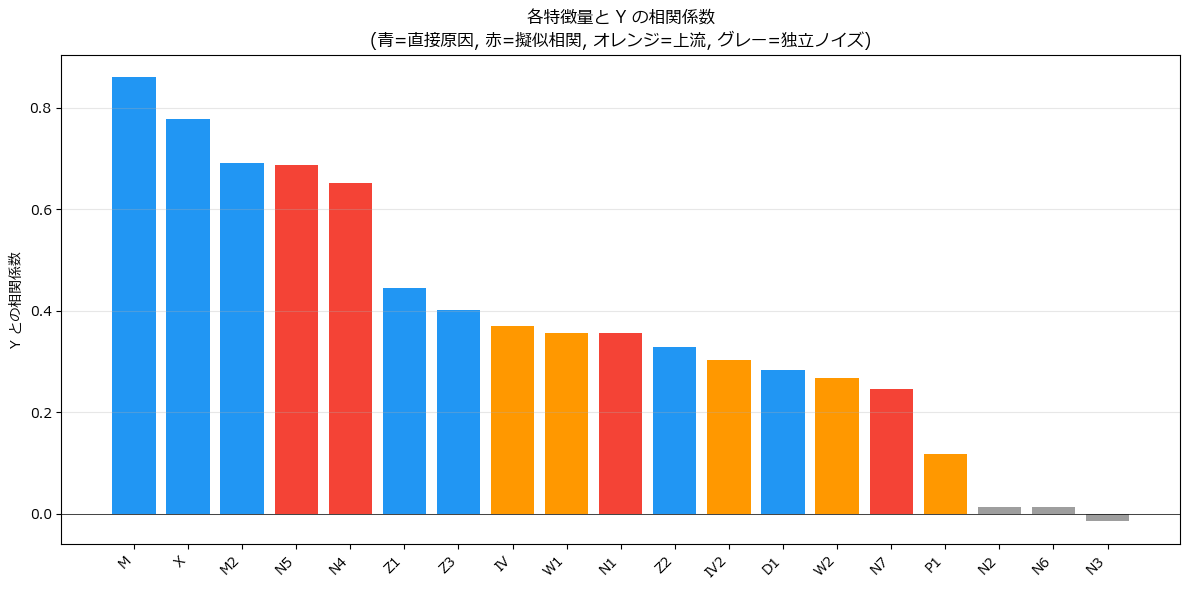


--- 擬似相関変数の相関係数 ---
  N1: r = 0.355  ← Y に因果効果なし！
  N4: r = 0.651  ← Y に因果効果なし！
  N5: r = 0.687  ← Y に因果効果なし！
  N7: r = 0.247  ← Y に因果効果なし！


In [2]:
# 真の因果構造を定義
DIRECT_CAUSES = ['X', 'M', 'M2', 'Z1', 'Z2', 'Z3', 'D1']
SPURIOUS_CORR = ['N1', 'N4', 'N5', 'N7']   # Y と擬似相関あり
INDEPENDENT   = ['N2', 'N3', 'N6']          # Y と無関係
UPSTREAM      = ['W1', 'W2', 'IV', 'IV2', 'P1']  # 間接的影響のみ

# Y との相関係数を確認
features = [c for c in df.columns if c != 'Y']
correlations = df[features].corrwith(df['Y']).sort_values(ascending=False)

# カテゴリで色分け
colors = []
for feat in correlations.index:
    if feat in DIRECT_CAUSES:
        colors.append('#2196F3')  # 青: 直接原因
    elif feat in SPURIOUS_CORR:
        colors.append('#F44336')  # 赤: 擬似相関
    elif feat in INDEPENDENT:
        colors.append('#9E9E9E')  # グレー: 独立
    else:
        colors.append('#FF9800')  # オレンジ: 上流

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(range(len(correlations)), correlations.values, color=colors)
ax.set_xticks(range(len(correlations)))
ax.set_xticklabels(correlations.index, rotation=45, ha='right')
ax.set_ylabel('Y との相関係数')
ax.set_title('各特徴量と Y の相関係数\n(青=直接原因, 赤=擬似相関, オレンジ=上流, グレー=独立ノイズ)')
ax.axhline(y=0, color='black', linewidth=0.5)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print('\n--- 擬似相関変数の相関係数 ---')
for feat in SPURIOUS_CORR:
    print(f'  {feat}: r = {correlations[feat]:.3f}  ← Y に因果効果なし！')

**観察ポイント**: N1, N4, N5, N7 は Y に対して因果効果がないにもかかわらず、
有意な相関を示しています。これが擬似相関です。

相関だけでは、直接原因（青）と擬似相関（赤）を区別できません。

---
次のノートブック: [02_shap_analysis.ipynb](02_shap_analysis.ipynb) で SHAP による特徴量重要度を分析します。